In [1]:
import sys
sys.path.append('/home/meiri.yoav/biomed_proj/pyPPG')

from Prefiltering import*
from FiducialPoints import*
from Biomarkers2 import*
from Summary import*
from Statistics import*
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import glob
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix, classification_report
# set seed 42
np.random.seed(42)

Setup:

Input: 10 ppg cycles (each one represented as 1x30 feature vector, total 10x30 matrix)

Output: 0/1 (0: non_af, 1: af)



In [2]:
def sample_series(X, B, series_size):
    n = X.shape[0]
    idx = np.random.randint(0, n-series_size, B)
    onsets = np.zeros(B)
    X_sampled = np.zeros((B, series_size, X.shape[1]-3)) # substracting 3 because we ommit Tpi, sample_idx and os
    for i in range(B):
        X_sampled[i,:,:] = X.iloc[idx[i]:idx[i]+series_size,:].drop(columns=['Tpi', 'sample_idx', 'os'])
        # put in onsets[i] the onset value of the record in idx[i]
        onsets[i] = X.iloc[idx[i],:].os
        
    return X_sampled, onsets, idx


In [3]:
def excract_hrv_features(cycle_signal_30, fs):
    from hrvanalysis.extract_features import get_time_domain_features
    from hrvanalysis.extract_features import get_frequency_domain_features
    from hrvanalysis.extract_features import get_geometrical_features
    from hrvanalysis.extract_features import get_poincare_plot_features
    from hrvanalysis.extract_features import get_csi_cvi_features
    import pandas as pd

    ''' reference: https://aura-healthcare.github.io/hrv-analysis/hrvanalysis.html'''

    time_domain_features = get_time_domain_features(cycle_signal_30)
    frequency_domain_features = get_frequency_domain_features(cycle_signal_30, sampling_frequency=fs)
    # geometrical_features = get_geometrical_features(cycle_signal_30)
    poincare_plot_features = get_poincare_plot_features(cycle_signal_30)
    csi_cvi_features = get_csi_cvi_features(cycle_signal_30)

    # aggregate all features into one dict and turn it into a dataframe
    features = {
                **time_domain_features,
                **frequency_domain_features,
                # **geometrical_features,
                **poincare_plot_features,
                **csi_cvi_features
                }
    features_arr = pd.DataFrame(features, index=[0]).to_numpy()
    return features_arr.squeeze()

def get_outlier_bounds(arr):
    q1 = np.quantile(arr, 0.25)
    q3 = np.quantile(arr, 0.75)
    iqr = q3-q1
    lower_bound = q1 - 1.5*iqr
    upper_bound = q3 + 1.5*iqr
    return lower_bound, upper_bound


In this setup we trainon sampled 30 cycle long series and test & validate on non-sampled (sliced) 30 cycle long series.

In [4]:
import random
from sklearn.impute import KNNImputer
from hrvanalysis.preprocessing import get_nn_intervals

B = 100# 1000 10 cycle long samples for each subject
series_size = 30
fs = 125
add_hrv = False
add_morph = True

annot_files = sorted(glob.glob("/home/meiri.yoav/biomed_proj/data/annotated/*"))
af_files = [f for f in annot_files if 'non' not in f]
non_af_files = [f for f in annot_files if 'non' in f]

names = [tuple(f.split('/')[-1].split('.')[0].split('_')[1:]) for f in annot_files]
non_af_subs = [t  for t in list(names) if 'non' in t]
af_subs = [t  for t in list(names) if 'non' not in t]

train_subs = non_af_subs[:int(len(non_af_subs)*0.8)] + af_subs[:int(len(af_subs)*0.8)]
test_subs = non_af_subs[int(len(non_af_subs)*0.8):] + af_subs[int(len(af_subs)*0.8):]

# print how much af and non af subjects we have in train and test sets
print(f'af subjects in train set: {len([s for s in train_subs if "non" not in s])}')
print(f'non af subjects in train set: {len([s for s in train_subs if "non" in s])}')
print(f'af subjects in test set: {len([s for s in test_subs if "non" not in s])}')
print(f'non af subjects in test set: {len([s for s in test_subs if "non" in s])}')

subs_features = {}
for f in annot_files:
    sub_name = tuple(f.split('/')[-1].split('.')[0].split('_')[1:])
    # print(f'processing {sub_name}')
    subs_features[sub_name] = {}
    with open(f, 'rb') as f:
        annot = pkl.load(f)

    
    X = annot['osignal_data']


    if sub_name in train_subs:
        # sample a random number between 0 and 
        # upper_bound = random.randint(0, int(len(X)/5))
        test_subset = X.iloc[0:int(len(X)/5),:] # take the first 20% of the data as test subset
        
        first_index_of_X = int(len(X)/5)
        # remove test subset from X
        X = X.drop(test_subset.index)
        
        
        signal = annot['hr']
        peaks = annot['fiducials']['pk']
        # # compute lower and upper bound that can be used for outlier removal
        # lower_bound, upper_bound = get_outlier_bounds(raw_signal)
        # signal = get_nn_intervals(annot['hr'], low_rri=lower_bound, high_rri=upper_bound)
        
        #? Setup test and validation sets
        # devide test subset to 30 cycle long series and pad with zeros if needed
        test_series = np.zeros((int(len(test_subset)/series_size), series_size, test_subset.shape[1]-3)) # substracting 3 because we ommit Tpi, sample_idx and os
        # test_onsets = []
        hrv_features = []
        for i in range(int(len(test_subset)/series_size)):
            # # put in test_onsets[i] the onset value of the record in idx[i]
            # if i == int(len(test_subset)/series_size)-1:
            #     test_onsets.append((test_subset.iloc[i*series_size,:].os, X.iloc[0,:].os)) # the ending of the last series is the beginning of the first series in X
            # else:
            #     test_onsets.append((test_subset.iloc[i*series_size,:].os, test_subset.iloc[(i+1)*series_size-1,:].os))
            
            # take peaks[i*series_size:(i+1)*series_size] and substract from each element it's previous element 
            if add_hrv:
                right_bound = min((i+1)*series_size+1, len(peaks))
                nn_intervals = np.diff(peaks[i*series_size : right_bound])
                # print(i, ': ', nn_intervals.shape, excract_hrv_features(nn_intervals, fs).shape)
                hrv_features.append(excract_hrv_features(nn_intervals, fs))
            
            if add_morph:
                test_series[i,:,:] = test_subset.iloc[i*series_size:(i+1)*series_size,:].drop(columns=['Tpi', 'sample_idx', 'os'])
        
        # print(np.array(hrv_features).shape)
        if add_hrv:
            # add hrv features to test_series
            hrv_features = np.array([hrv_features for i in range(series_size)]).reshape((len(hrv_features), series_size, hrv_features[0].shape[0]))
            test_series = np.concatenate((test_series, hrv_features), axis=2)
        
        # if add_hrv:
        #     # extract hrv features from test_series
        #     test_hrv_features = np.nan_to_num(np.vstack(list(map(lambda x: excract_hrv_features(signal[int(x[0]):int(x[1])], fs), test_onsets))))
        #     # add hrv features to test_series
        #     test_hrv_features = np.array([test_hrv_features for i in range(series_size)]).reshape((test_hrv_features.shape[0], series_size, test_hrv_features.shape[1]))
        #     test_series = np.concatenate((test_series, test_hrv_features), axis=2)

        # split test_series to val split and test split and add them both to subs_features
        subs_features[sub_name]['val_split'] = test_series[:int(len(test_series)/2)]
        subs_features[sub_name]['test_split'] = test_series[int(len(test_series)/2):]
        
        #? Setup train set
        
        data, onsets, idx = sample_series(X, B, series_size)

        if not add_morph:
            # make data an array of zeros of the same shape as data
            data = np.zeros(data.shape)
        # print(data.shape)
        if add_hrv:
            hrv_features = []
            for i in range(B):
                right_bound = min(first_index_of_X+idx[i]+series_size+1, len(peaks))
                nn_intervals = np.diff(peaks[first_index_of_X+idx[i] : right_bound])
                hrv_features.append(excract_hrv_features(nn_intervals, fs))
                
            hrv_features = np.array([hrv_features for i in range(series_size)]).reshape((len(hrv_features), series_size, hrv_features[0].shape[0]))
            data = np.concatenate((data, hrv_features), axis=2)
            
            # train_onsets = [(onsets[i], onsets[i+1]) if i < len(onsets)-1 else (onsets[i], len(signal)) for i in range(len(onsets)-1)]
            # # extract hrv features from train_series
            # train_hrv_features= np.nan_to_num(np.vstack(list(map(lambda x: excract_hrv_features(signal[int(x[0]):int(x[1])], fs), train_onsets))))
            # # add hrv features to train_series
            # train_hrv_features = np.array([train_hrv_features for i in range(series_size)]).reshape((train_hrv_features.shape[0], series_size, train_hrv_features.shape[1])) # to all series vectors add the same hrv features (because the characterize the whole record and not every beat)
            # data = np.concatenate((data, train_hrv_features), axis=2)
        
        
        subs_features[sub_name]['train_split'] = data
    else:
        # print('test_sub')
        # In this case just split to 30 cycle long series and pad with zeros if needed
        data = np.zeros((int(len(X)/series_size), series_size, X.shape[1]-3))
        # test_onsets = []
        hrv_features = []
        for i in range(int(len(X)/series_size)):
            # if i == int(len(test_subset)/series_size)-1:
            #     test_onsets.append((X.iloc[i*series_size,:].os, len(signal)))
            # else:
            #     test_onsets.append((X.iloc[i*series_size,:].os, X.iloc[(i+1)*series_size-1,:].os))
            
            if add_hrv:
                right_bound = min((i+1)*series_size+1, len(peaks))
                if right_bound <= i*series_size:
                    continue
                # print((i*series_size, right_bound))
                nn_intervals = np.diff(peaks[i*series_size : right_bound])
                if len(nn_intervals) == 0:
                    continue
                hrv_features.append(excract_hrv_features(nn_intervals, fs))
            if add_morph:
                data[i,:,:] = X.iloc[i*series_size:(i+1)*series_size,:].drop(columns=['Tpi', 'sample_idx', 'os'])
        
        if add_hrv:
            # add hrv features to test_series
            hrv_features = np.array([hrv_features for i in range(series_size)]).reshape((len(hrv_features), series_size, hrv_features[0].shape[0]))
            # print(hrv_features.shape)
            data = np.concatenate((data[:len(hrv_features),:,:], hrv_features), axis=2)
        
        # if add_hrv:
        #     # extract hrv features from test_series
        #     test_hrv_features = np.nan_to_num(np.vstack(list(map(lambda x: excract_hrv_features(signal[int(x[0]):int(x[1])], fs), test_onsets))))
        #     # add hrv features to test_series
        #     test_hrv_features = np.array([test_hrv_features for i in range(series_size)]).reshape((test_hrv_features.shape[0],series_size, test_hrv_features.shape[1]))
        #     data = np.concatenate((data, test_hrv_features), axis=2)
        # split data to val split and test split and add them both to subs_features
        subs_features[sub_name]['val_split'] = data[:int(len(data)/2)]
        subs_features[sub_name]['test_split'] = data[int(len(data)/2):]
        

# print the name and the shapes of all subs in subs_features, and consider if it's a train sub or a test sub
for sub in subs_features.keys():
    if sub in train_subs:
        print(sub, subs_features[sub]['train_split'].shape, subs_features[sub]['val_split'].shape, subs_features[sub]['test_split'].shape)
    else:
        print(sub, subs_features[sub]['val_split'].shape, subs_features[sub]['test_split'].shape)


af subjects in train set: 14
non af subjects in train set: 12
af subjects in test set: 4
non af subjects in test set: 3
('af', '001') (100, 30, 30) (5, 30, 30) (6, 30, 30)
('af', '002') (100, 30, 30) (4, 30, 30) (5, 30, 30)
('af', '003') (100, 30, 30) (4, 30, 30) (5, 30, 30)
('af', '005') (100, 30, 30) (4, 30, 30) (4, 30, 30)
('af', '006') (100, 30, 30) (5, 30, 30) (5, 30, 30)
('af', '007') (100, 30, 30) (5, 30, 30) (5, 30, 30)
('af', '008') (100, 30, 30) (5, 30, 30) (5, 30, 30)
('af', '009') (100, 30, 30) (5, 30, 30) (6, 30, 30)
('af', '010') (100, 30, 30) (5, 30, 30) (5, 30, 30)
('af', '011') (100, 30, 30) (5, 30, 30) (6, 30, 30)
('af', '012') (100, 30, 30) (5, 30, 30) (5, 30, 30)
('af', '013') (100, 30, 30) (5, 30, 30) (5, 30, 30)
('af', '014') (100, 30, 30) (5, 30, 30) (6, 30, 30)
('af', '015') (100, 30, 30) (4, 30, 30) (5, 30, 30)
('af', '016') (29, 30, 30) (29, 30, 30)
('af', '017') (24, 30, 30) (24, 30, 30)
('af', '018') (29, 30, 30) (30, 30, 30)
('af', '019') (27, 30, 30) (28, 

In [14]:
def create_dataset(sub_features):
    # devide to train and test subjects where both train and test groups contain all the classes
    
    
    X_train = np.concatenate([sub_features[t]['train_split'] for t in train_subs], axis=0) # amoung the train subjects, take 80% of each subject to train set
    y_train = np.concatenate([np.ones(int(sub_features[t]['train_split'].shape[0]))*int('non' not in t) for t in train_subs], axis=0)
    
    X_val_from_train_subs = np.concatenate([sub_features[t]['val_split'] for t in train_subs], axis=0)
    y_val_from_train_subs = np.concatenate([np.ones(int(sub_features[t]['val_split'].shape[0]))*int('non' not in t) for t in train_subs], axis=0)
    # shuffle X_val_from_train_subs and y_val_from_train_subs togather
    idx = np.random.permutation(X_val_from_train_subs.shape[0])
    X_val_from_train_subs = X_val_from_train_subs[idx]
    y_val_from_train_subs = y_val_from_train_subs[idx]
    
    X_test_from_train_subs = np.concatenate([sub_features[t]['test_split'] for t in train_subs], axis=0)
    y_test_from_train_subs = np.concatenate([np.ones(int(sub_features[t]['test_split'].shape[0]))*int('non' not in t) for t in train_subs], axis=0)
    # print(y_test_from_train_subs.shape, X_test_from_train_subs.shape)
    # for i in range(len(y_test_from_train_subs)):
    #     print(y_test_from_train_subs[i], X_test_from_train_subs[i].shape)
    X_val_from_test_subs = np.concatenate([sub_features[t]['val_split'] for t in test_subs], axis=0)
    y_val_from_test_subs = np.concatenate([np.ones(int(sub_features[t]['val_split'].shape[0]))*int('non' not in t) for t in test_subs], axis=0)
    
    X_test_from_test_subs = np.concatenate([sub_features[t]['test_split'] for t in test_subs], axis=0)
    y_test_from_test_subs = np.concatenate([np.ones(int(sub_features[t]['test_split'].shape[0]))*int('non' not in t) for t in test_subs], axis=0)
    
    
    return X_train, y_train, X_val_from_train_subs, y_val_from_train_subs, X_test_from_train_subs, y_test_from_train_subs, X_val_from_test_subs, y_val_from_test_subs, X_test_from_test_subs, y_test_from_test_subs, train_subs, test_subs
    

    
X_train, y_train, X_val_from_train_subs, y_val_from_train_subs, X_test_from_train_subs, y_test_from_train_subs, X_val_from_test_subs, y_val_from_test_subs, X_test_from_test_subs, y_test_from_test_subs, train_subs, test_subs = create_dataset(subs_features)
# print the shapes of the data
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_val_from_train_subs shape: ', X_val_from_train_subs.shape)
print('y_val_from_train_subs shape: ', y_val_from_train_subs.shape)
print('X_test_from_train_subs shape: ', X_test_from_train_subs.shape)
print('y_test_from_train_subs shape: ', y_test_from_train_subs.shape)
print('X_val_from_test_subs shape: ', X_val_from_test_subs.shape)
print('y_val_from_test_subs shape: ', y_val_from_test_subs.shape)
print('X_test_from_test_subs shape: ', X_test_from_test_subs.shape)
print('y_test_from_test_subs shape: ', y_test_from_test_subs.shape)

print('train_subs: ', train_subs)
print('test_subs: ', test_subs)

X_train shape:  (2600, 30, 30)
y_train shape:  (2600,)
X_val_from_train_subs shape:  (122, 30, 30)
y_val_from_train_subs shape:  (122,)
X_test_from_train_subs shape:  (135, 30, 30)
y_test_from_train_subs shape:  (135,)
X_val_from_test_subs shape:  (184, 30, 30)
y_val_from_test_subs shape:  (184,)
X_test_from_test_subs shape:  (187, 30, 30)
y_test_from_test_subs shape:  (187,)
train_subs:  [('non', 'af', '001'), ('non', 'af', '002'), ('non', 'af', '003'), ('non', 'af', '005'), ('non', 'af', '006'), ('non', 'af', '007'), ('non', 'af', '008'), ('non', 'af', '009'), ('non', 'af', '010'), ('non', 'af', '011'), ('non', 'af', '012'), ('non', 'af', '013'), ('af', '001'), ('af', '002'), ('af', '003'), ('af', '005'), ('af', '006'), ('af', '007'), ('af', '008'), ('af', '009'), ('af', '010'), ('af', '011'), ('af', '012'), ('af', '013'), ('af', '014'), ('af', '015')]
test_subs:  [('non', 'af', '014'), ('non', 'af', '015'), ('non', 'af', '016'), ('af', '016'), ('af', '017'), ('af', '018'), ('af', '0

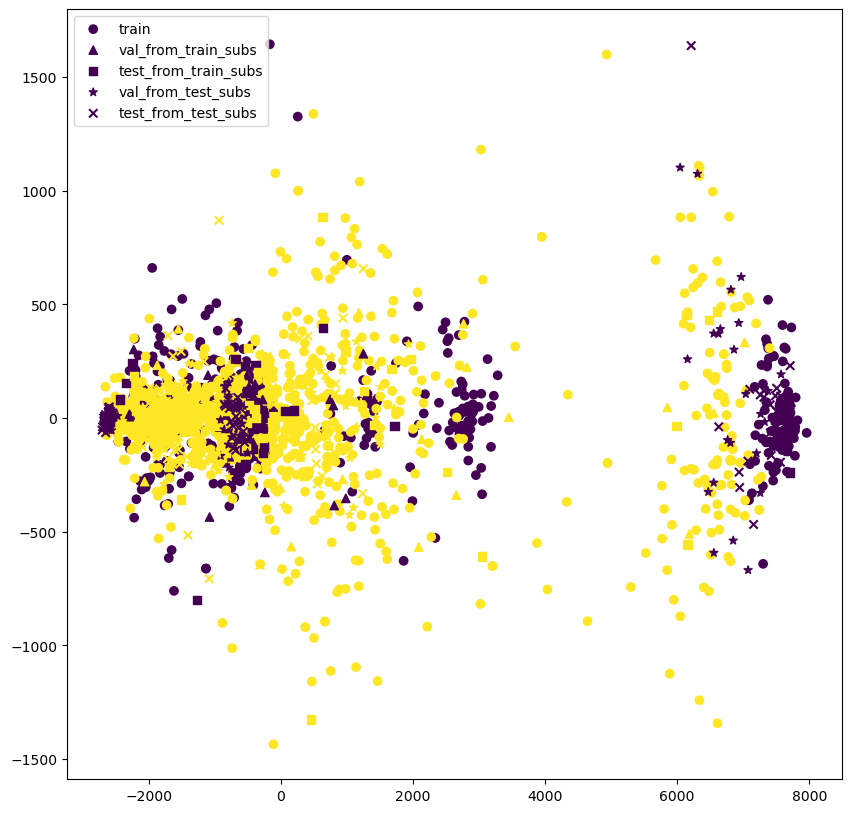

In [15]:
# plot all data on 2d using pca and color the data by the labels

pca = PCA(n_components=2)

# create one big stacked X and y
X = np.concatenate([X_train, X_val_from_train_subs, X_test_from_train_subs, X_val_from_test_subs, X_test_from_test_subs], axis=0)
# fit transform X and devide it to the original sets
X_pca = pca.fit_transform(X.reshape((X.shape[0], X.shape[1]*X.shape[2])))
X_train_pca = X_pca[:X_train.shape[0]]
X_val_from_train_subs_pca = X_pca[X_train.shape[0]:X_train.shape[0]+X_val_from_train_subs.shape[0]]
X_test_from_train_subs_pca = X_pca[X_train.shape[0]+X_val_from_train_subs.shape[0]:X_train.shape[0]+X_val_from_train_subs.shape[0]+X_test_from_train_subs.shape[0]]
X_val_from_test_subs_pca = X_pca[X_train.shape[0]+X_val_from_train_subs.shape[0]+X_test_from_train_subs.shape[0]:X_train.shape[0]+X_val_from_train_subs.shape[0]+X_test_from_train_subs.shape[0]+X_val_from_test_subs.shape[0]]
X_test_from_test_subs_pca = X_pca[X_train.shape[0]+X_val_from_train_subs.shape[0]+X_test_from_train_subs.shape[0]+X_val_from_test_subs.shape[0]:]

# X_train_pca = pca.fit_transform(X_train.reshape((X_train.shape[0], X_train.shape[1]*X_train.shape[2])))
# X_val_from_train_subs_pca = pca.transform(X_val_from_train_subs.reshape((X_val_from_train_subs.shape[0], X_val_from_train_subs.shape[1]*X_val_from_train_subs.shape[2])))
# X_test_from_train_subs_pca = pca.transform(X_test_from_train_subs.reshape((X_test_from_train_subs.shape[0], X_test_from_train_subs.shape[1]*X_test_from_train_subs.shape[2])))
# X_val_from_test_subs_pca = pca.transform(X_val_from_test_subs.reshape((X_val_from_test_subs.shape[0], X_val_from_test_subs.shape[1]*X_val_from_test_subs.shape[2])))
# X_test_from_test_subs_pca = pca.transform(X_test_from_test_subs.reshape((X_test_from_test_subs.shape[0], X_test_from_test_subs.shape[1]*X_test_from_test_subs.shape[2])))
# print(X_train_pca.shape)
# print(X_val_from_train_subs_pca.shape)    
# print(X_test_from_train_subs_pca.shape)
# print(X_val_from_test_subs_pca.shape)

# plot the data colors are according to labels and shapes are according to the set (train, val, test)
plt.figure(figsize=(10,10))
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c=y_train, marker='o', label='train')
plt.scatter(X_val_from_train_subs_pca[:,0], X_val_from_train_subs_pca[:,1], c=y_val_from_train_subs, marker='^', label='val_from_train_subs')
plt.scatter(X_test_from_train_subs_pca[:,0], X_test_from_train_subs_pca[:,1], c=y_test_from_train_subs, marker='s', label='test_from_train_subs')
plt.scatter(X_val_from_test_subs_pca[:,0], X_val_from_test_subs_pca[:,1], c=y_val_from_test_subs, marker='*', label='val_from_test_subs')
plt.scatter(X_test_from_test_subs_pca[:,0], X_test_from_test_subs_pca[:,1], c=y_test_from_test_subs, marker='x', label='test_from_test_subs')
plt.legend()
plt.show()

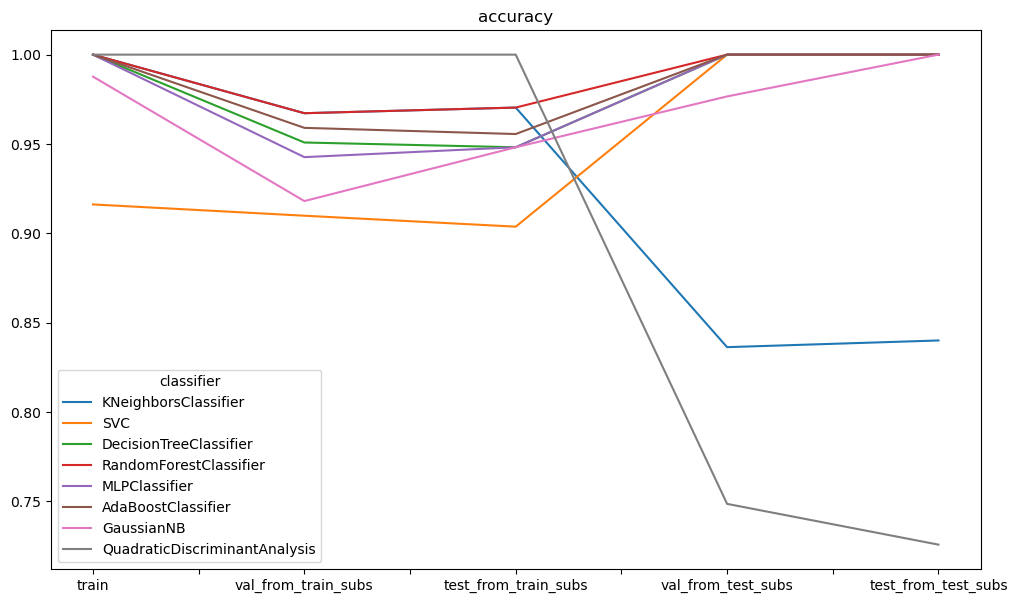

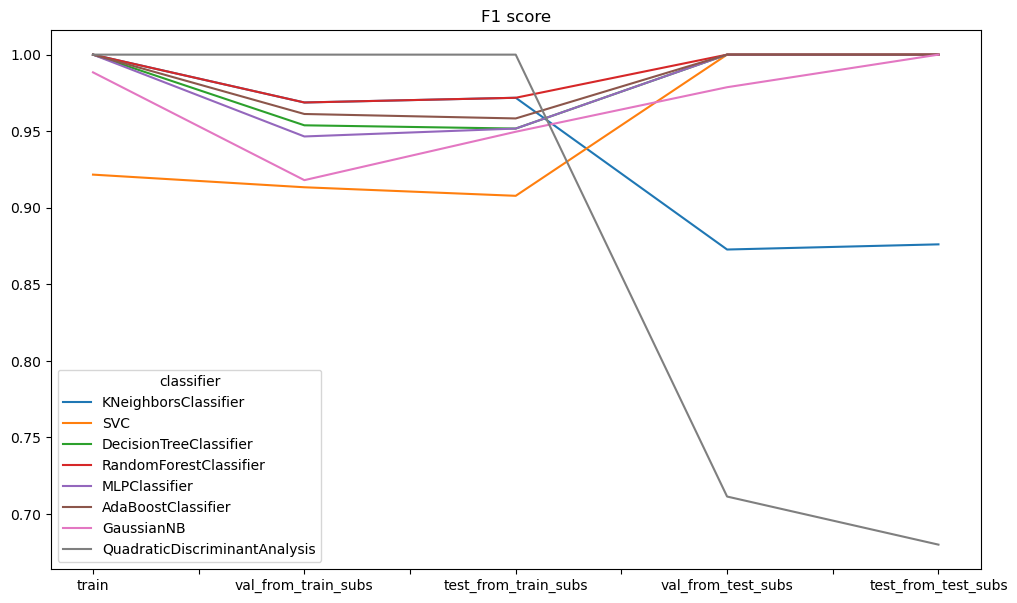

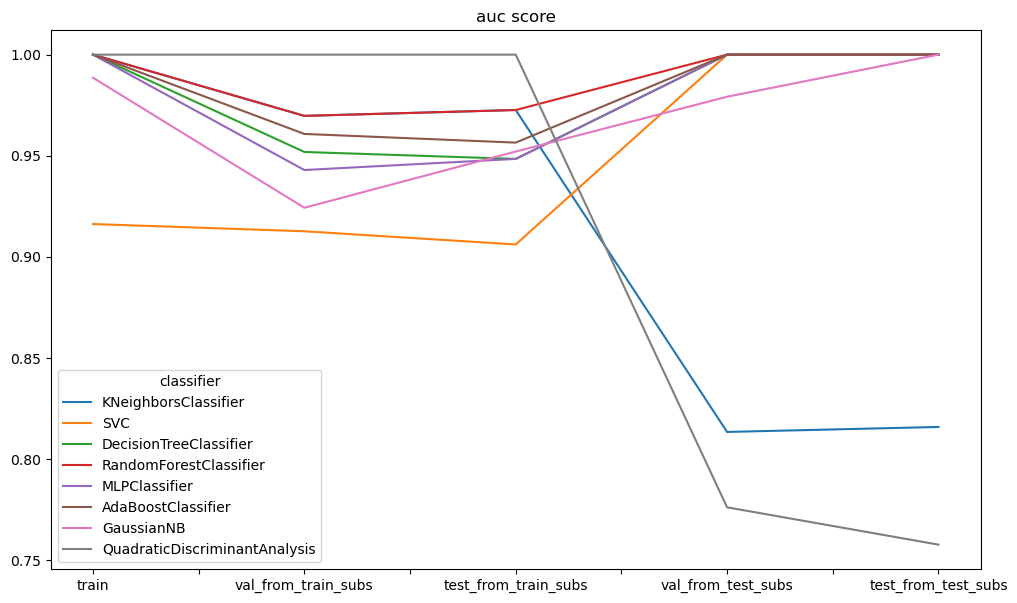

metric                           accuracy                                   \
classifier           KNeighborsClassifier       SVC DecisionTreeClassifier   
train                                 1.0  0.916154                    1.0   
val_from_train_subs              0.967213  0.909836                0.95082   
test_from_train_subs              0.97037  0.903704               0.948148   
val_from_test_subs               0.836257       1.0                    1.0   
test_from_test_subs                  0.84       1.0                    1.0   

metric                                                                        \
classifier           RandomForestClassifier MLPClassifier AdaBoostClassifier   
train                                   1.0           1.0                1.0   
val_from_train_subs                0.967213      0.942623           0.959016   
test_from_train_subs                0.97037      0.948148           0.955556   
val_from_test_subs                      1.0           1.0                1.0   
test_from_test_subs                     1.0           1.0                1.0   

metric                                                         \
classifier           GaussianNB QuadraticDiscriminantAnalysis   
train                  0.987692                           1.0   
val_from_train_subs    0.918033                           1.0   
test_from_train_subs   0.948148                           1.0   
val_from_test_subs     0.976608                      0.748538   
test_from_test_subs         1.0                      0.725714   

metric                           F1 score            ...             \
classifier           KNeighborsClassifier       SVC  ... GaussianNB   
train                                 1.0  0.921639  ...   0.988439   
val_from_train_subs               0.96875  0.913386  ...   0.918033   
test_from_train_subs             0.971831  0.907801  ...    0.94964   
val_from_test_subs               0.872727       1.0  ...   0.978723   
test_from_test_subs              0.876106       1.0  ...        1.0   

metric                                                        auc score  \
classifier           QuadraticDiscriminantAnalysis KNeighborsClassifier   
train                                          1.0                  1.0   
val_from_train_subs                            1.0             0.969697   
test_from_train_subs                           1.0             0.972603   
val_from_test_subs                        0.711409             0.813333   
test_from_test_subs                           0.68             0.815789   

metric                                                                        \
classifier                 SVC DecisionTreeClassifier RandomForestClassifier   
train                  0.91619                    1.0                    1.0   
val_from_train_subs   0.912608                0.95184               0.969697   
test_from_train_subs  0.906098               0.948409               0.972603   
val_from_test_subs         1.0                    1.0                    1.0   
test_from_test_subs        1.0                    1.0                    1.0   

metric                                                            \
classifier           MLPClassifier AdaBoostClassifier GaussianNB   
train                          1.0                1.0   0.988571   
val_from_train_subs       0.942911           0.960768   0.924242   
test_from_train_subs      0.948409           0.956474   0.952055   
val_from_test_subs             1.0                1.0   0.979167   
test_from_test_subs            1.0                1.0        1.0   

metric                                              
classifier           QuadraticDiscriminantAnalysis  
train                                          1.0  
val_from_train_subs                            1.0  
test_from_train_subs                           1.0  
val_from_test_subs                        0.776042  
test_from_test_subs                       0.757576  

[5

In [22]:

import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# For all data partitions, average the data along axis 1 (the time axis), and build a logistic regression classifier
# for each partition, print the accuracy of the classifier on the partition

# average the data along axis 1 (the time axis)
X_train_mean = np.mean(X_train, axis=1)
X_val_from_train_subs_mean = np.mean(X_val_from_train_subs, axis=1)
X_test_from_train_subs_mean = np.mean(X_test_from_train_subs, axis=1)
X_val_from_test_subs_mean = np.mean(X_val_from_test_subs, axis=1)
X_test_from_test_subs_mean = np.mean(X_test_from_test_subs, axis=1)

# create multiple sklearn classifiers, for each classifier, fit the classifier on the training data, and compute scores using compute_scores on each partition. plot the results in a single plot
classifiers = [KNeighborsClassifier(3),
                SVC(kernel="rbf", C=0.025, probability=True),
                DecisionTreeClassifier(max_depth=5),
                RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
                MLPClassifier(alpha=1, max_iter=1000),
                AdaBoostClassifier(),
                GaussianNB(),
                QuadraticDiscriminantAnalysis(),
                ]
# for each metric, compute the metric for all classifiers on all partitions, and create a line plot for each metric describing all classifiers on all partitions, partitions are on the x-axis, and the metric is on the y-axis
metrics = ['accuracy', 'F1 score', 'auc score']

# create a dataframe to store the results with the columns as the (metric, classifier) pairs for all suych pairs and the rows as the partitions
results = pd.DataFrame(columns=pd.MultiIndex.from_product([metrics, [clf.__class__.__name__ for clf in classifiers]], names=['metric', 'classifier']), index=['train', 'val_from_train_subs', 'test_from_train_subs', 'val_from_test_subs', 'test_from_test_subs'])
# full the results dataframe with the scores, and create a seperate function to compute the scores
def compute_score(X, y, partition, clf):
    # compute the accuracy, F1 score and auc score of the classifier on each partition
    y_pred = clf.predict(X)
    results.loc[partition, ('accuracy', clf.__class__.__name__)] = accuracy_score(y, y_pred)
    results.loc[partition, ('F1 score', clf.__class__.__name__)] = f1_score(y, y_pred)
    results.loc[partition, ('auc score', clf.__class__.__name__)] = roc_auc_score(y, y_pred)

# for each classifier, fit the classifier on the training data, and compute scores using compute_scores on each partition. plot the results in a single plot
for clf in classifiers:
    # print(clf.__class__.__name__)
    clf.fit(X_train_mean, y_train)
    compute_score(X_train_mean, y_train, 'train', clf)
    compute_score(X_val_from_train_subs_mean, y_val_from_train_subs, 'val_from_train_subs', clf)
    compute_score(X_test_from_train_subs_mean, y_test_from_train_subs, 'test_from_train_subs', clf)
    compute_score(X_val_from_test_subs_mean, y_val_from_test_subs, 'val_from_test_subs', clf)
    compute_score(X_test_from_test_subs_mean, y_test_from_test_subs, 'test_from_test_subs', clf)
    
# Create a line plot for each metric describing all classifiers on all partitions, partitions are on the x-axis, and the metric is on the y-axis
for metric in metrics:
    results[metric].plot.line(figsize=(12, 7))
    plt.title(metric)
    plt.show()


results
